# 불균형 데이터로 신용카드 사기탐지 모델 구현하기


1. 불균형 데이터 분류 문제에 대한 이해 
    - 이자료는 신용카드 사기와 정상을 다루는데 사기(1)의 데이터셋 갯수는 492개, 정상(0)의 데이터셋 갯수는 284315 로 불균형 자료임
2. 피처 변환 알고리즘의 이해
3. 과대적합 발생시 해결 방법 습득
4. 리샘플링 알고리즘에 대한 이해
5. 불균형 데이터를 이용한 분류 결과의 올바른 해석 방법 습득

- 1) 불균형 분류 문제에 대한 이해: 사기탐지 데이터
- 2) 피처 변환 알고리즘의 이해: <b>PCA</b>, <b>t-SNE</b>, <b>SVD</b>
- 3) 과대적합 발생시 해결 방법 습득: 모델 파라미터 조정, 샘플 재구축
- 4) 리샘플링 알고리즘에 대한 이해: <b>Random Undersampling</b>, <b>Random Oversampling</b>, <b>SMOTE Oversampling</b> 등
- 5) 불균형 데이터를 이용한 분류 결과의 올바른 해석 방법 습득: `classification_report_imbalanced` 이용하기

## [1] 사기탐지 분류 모형 개요

### 금융 데이터의 특성 (Review)
- 1) 이종(heterogeneous) 데이터의 결합
- 2) <b>분포의 편향성(skewness)</b>
- 3) 분류 레이블의 불명확성
- 4) 변수의 다중공선성(multicollinearity)
- 5) 변수의 비선형성
- 그 외 현실적인 규제·수집·저장 등의 한계 때문에 데이터가 불완전(missing, truncated, censored)할 수 있음

사기탐지(Fraud Detection) 분류는 주로 2)와 관련한 금융 데이터의 특성을 가진 문제입니다. 

### 불균형 데이터의 머신러닝

- 데이터 불균형(Imbalanced Data): 머신러닝의 지도학습에서 분류하기 위한 각 클래스(레이블)에 해당하는 데이터의 양에 차이가 큰 경우
- 특정 클래스가 부족할 때 생기는 문제: (1) 과대적합, (2) 알고리즘이 수렴하지 않는 현상 발생


- 1) X (피처)의 불균형
    - 범주변수일 경우 범주에 따라 빈도가 낮을 수 있음
    - 고차원 피처 공간의 축소(Feature Transformation)
    - PCA, t-SNE 등의 알고리즘 사용
    
    
- 2) y (타겟)의 불균형
    - 여신(대출), 수신(적금), 보험(클레임), 카드(사기탐지), 거시경제(불황) 등 대부분의 금융 데이터는 희소 타겟 문제
    - 리샘플링(Resampling)으로 저빈도 데이터를 극복
    - 무선 과대표집(Random Oversampling), 무선 과소표집(Random Undersampling), SMOTE, Tomek Links 등의 알고리즘 사용

## [2] 데이터를 학습에 맞게 변환하기

- 데이터 소개
https://www.kaggle.com/mlg-ulb/creditcardfraud

1. V1 ~ V28 : 개인정보로 공개되지 않은 값
2. Time : 시간
3. Amount : 거래금액
4. Class : 사기 여부 (1: 사기, 0: 정상)

In [2]:
import numpy as np  
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings("ignore")

### 2-1. 데이터 확인하기

In [4]:
# 파일 불러오기
df = pd.read_csv('fraud.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [6]:
# 로드한 데이터의 맨 윗 30개 행 확인하기
df.head(30)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [7]:
# Missing 여부 확인하기
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [8]:
# 불러온 데이터의 클래스 분포 확인하기
df.groupby(by=['Class']).count()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Class,,,,,,,,,,,,,,,,,,,,,
0,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,...,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315
1,492,492,492,492,492,492,492,492,492,492,...,492,492,492,492,492,492,492,492,492,492


In [9]:
print('Target class is ', '{0:0.4f}'. format(492/(284315+492)*100), '%')

Target class is  0.1727 %


In [19]:
# 사기 여부 (1: 사기, 0: 정상)
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

### 2-2. 변수의 스케일 변환

### 참고: scikit-learn이 제공하는 스케일러 (Review)

scikit-learn에서 제공하는 피처 스케일러(scaler)
- `StandardScaler`: 기본 스케일, 각 피처의 평균을 0, 표준편차를 1로 변환
- `RobustScaler`: 위와 유사하지만 평균 대신 중간값(median)과 일분위, 삼분위값(quartile)을 사용하여 이상치 영향을 최소화
- `MinMaxScaler`: 모든 피처의 최대치와 최소치가 각각 1, 0이 되도록 스케일 조정
- `Normalizer`: 피처(컬럼)이 아니라 row마다 정규화되며, 유클리드 거리가 1이 되도록 데이터를 조정하여 빠르게 학습할 수 있게 함

<p> 스케일 조정을 하는 이유는 데이터의 값이 너무 크거나 작을 때 학습이 제대로 되지 않을 수도 있기 때문입니다. <b> 또한 스케일의 영향이 절대적인 분류기(예: knn과 같은 거리기반 알고리즘)의 경우, 스케일 조정을 필수적으로 검토해야 합니다. </b>
    
<p> 반면 어떤 항목은 원본 데이터의 분포를 유지하는 것이 나을 수도 있습니다. 예를 들어, 데이터가 거의 한 곳에 집중되어 있는 feature를 표준화시켜 분포를 같게 만들었을 때, 작은 단위의 변화가 큰 차이를 나타내는 것처럼 학습될 수도 있습니다. 또한 스케일의 영향을 크게 받지 않는 분류기(예: 트리 기반 앙상블 알고리즘)를 사용할 경우에도 성능이 준수하게 나오거나 과대적합(overfitting)의 우려가 적다면 생략할 수도 있습니다.
    
<p> <b>스케일 조정시 유의해야할 점은 원본 데이터의 의미를 잃어버릴 수 있다는 것입니다.</b> 최종적으로 답을 구하는 것이 목적이 아니라 모델의 해석이나 향후 다른 데이터셋으로의 응용이 더 중요할 때 원 피처에 대한 설명력을 잃어버린다면 모델 개선이 어려울 수도 있습니다. 이 점을 함께 고려하시면 좋겠습니다.

In [10]:
# 데이터 스케일 조정하기
from sklearn.preprocessing import StandardScaler, RobustScaler

std_scaler = StandardScaler()
rob_scaler = RobustScaler() ## 

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

# 원 데이터에서 Time 컬럼과 Amount 컬럼 제외하기
df.drop(['Time','Amount'], axis=1, inplace=True)

In [11]:
# 스케일 조정된 컬럼 추가하기
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

## 스케일 조정된 데이터 확인하기

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


### 2-3. train_test_split

In [13]:
# X와 y 데이터 셋 만들기
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold, StratifiedKFold

X = df.drop('Class', axis=1)
y = df['Class']

# 데이터 나누기
sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

In [15]:
# 클래스의 왜도(비대칭도,skew,한쪽으로 몰리는 현상) 정도가 매우 높기 때문에 클래스간 분포를 맞추는 것이 필요합니다.
# subsample 구축 전 셔플링을 통해 레이블이 한쪽에 몰려있지 않도록 하겠습니다.

df = df.sample(frac=1)

# 데이터 준비
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# 데이터 셔플하기
new_df = normal_distributed_df.sample(frac=1, random_state=0)

# 셔플한 새로운 데이터 셋 확인
new_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
276864,4.570391,0.970947,-1.374424,2.793185,-4.346572,2.400731,-1.688433,0.111136,-0.922038,-2.149930,...,0.650196,-0.870779,0.504849,0.137994,0.368275,0.103137,-0.414209,0.454982,0.096711,1
217149,-0.135401,0.659007,1.968605,0.198764,-2.135619,0.857570,0.270035,-1.222188,0.082188,-0.137738,...,-0.199056,0.030587,0.330718,-0.037038,-0.087684,0.127371,0.704133,-0.047468,-0.022721,0
86155,1.110878,-0.277071,-2.756007,0.683821,-1.390169,1.501887,-1.165614,-0.131207,-1.478741,-0.246922,...,-0.106945,0.320474,0.611027,0.174864,-0.502151,-0.174713,1.179242,-1.166315,0.821215,1
115266,-0.135401,-0.127833,1.200683,0.247418,0.124898,1.085100,-0.402721,-0.800746,-0.083425,-0.093484,...,-0.078940,-0.181508,-0.284732,-0.093724,0.335105,0.544868,0.411161,0.000795,0.042964,0
29583,1.787186,-0.577521,1.138546,-0.905831,-0.052347,-0.730905,-0.851105,-0.612491,-0.293122,-0.155208,...,0.371145,0.326058,0.527141,-0.288504,0.057430,0.593457,-0.128761,-0.036571,0.021207,0


## [3]. PCA와 t-SNE, SVD를 이용하여 차원 축소하기
개인정보 V1~V28개의 데이터셋의 주성분으로 작업

### 참고: 차원축소 방법
    
- 주성분 분석(Principal Component Analysis)
- t-SNE (Stochastic Neighbor Embedding)
    - SNE는 n 차원에 분포된 이산 데이터를 k(n 이하의 정수) 차원으로 축소하며 거리 정보를 보존하되, 거리가 가까운 데이터의 정보를 우선하여 보존하기 위해 고안되었음
    - 단어 벡터와 같이 고차원 데이터를 시각화하는 데 가장 자주 쓰이는 알고리즘
    - SNE 학습과정에 사용되는 가우시안 분포는 t 분포에 비해 거리에 따른 확률 값 변화의 경사가 가파른 특징을 가지기 때문에 특정 거리 이상부터는 학습과정에 거의 반영이 되지 않는 문제점을 가지고 있음(Crowding Problem)
    - 이러한 문제점을 보완하기 위해 고안된 방법이 t-SNE: 학습과정에서 가우시안 분포 대신 t 분포를 이용
    - t-SNE는 보통 word2vec으로 임베딩한 단어벡터를 시각화하는데 쓰임
    
- 특이값 분해(Singular Value Decomposition)
- 그 외 잠재 의미분석(Latent Semantic Analysis), 행렬 인수분해(Matrix Factorization) 등

실무에서는 스케일이 매우 큰 실제 데이터를 분석하기 위해서, 여러 방법론을 융합하여 사용하는 것이 필요

### 3-1. 차원 축소하기

In [21]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD

# 차원 축소할 데이터 준비
X = new_df.drop('Class', axis=1)
y = new_df['Class']

# t-SNE  
X_reduced_tsne = TSNE(n_components=2, random_state=0).fit_transform(X.values)
print('t-SNE done')

# PCA 
X_reduced_pca = PCA(n_components=2, random_state=0).fit_transform(X.values)
print('PCA done')

# TruncatedSVD
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=0).fit_transform(X.values)
print('Truncated SVD done')

t-SNE done
PCA done
Truncated SVD done


### 3-2. 결과 시각화하기

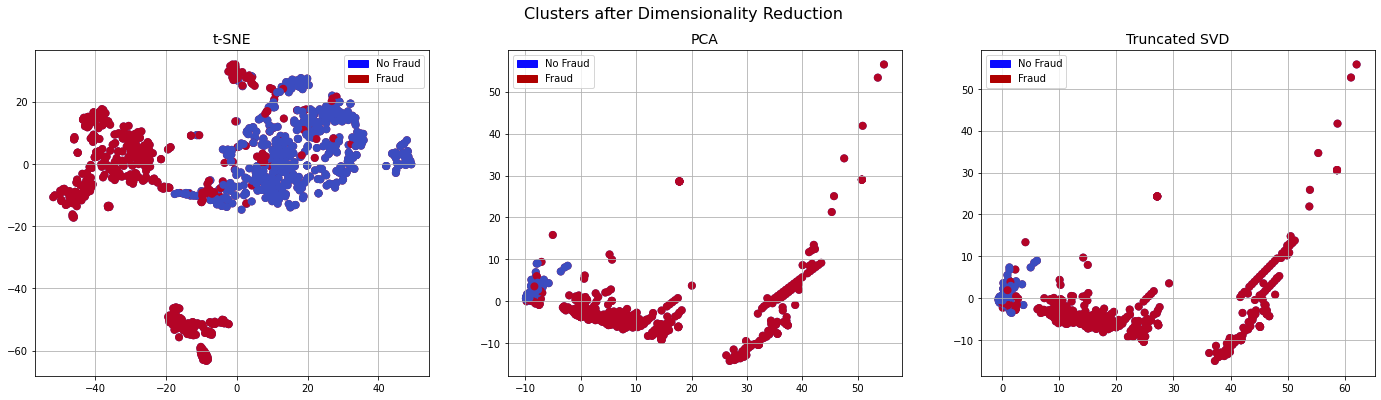

In [23]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))
f.suptitle('Clusters after Dimensionality Reduction', fontsize=16)

labels = ['No Fraud', 'Fraud']
blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')

# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)
ax1.grid(True)
ax1.legend(handles=[blue_patch, red_patch])

# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)
ax2.grid(True)
ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)
ax3.grid(True)
ax3.legend(handles=[blue_patch, red_patch])

plt.show()

## [4]. Random Undersampling 으로 샘플 재구축하기

### 4-1. 재구축 샘플로 분류모델 구현하기

In [24]:
# 재구축한 데이터의 클래스 분포 확인하기

new_df.groupby(by=['Class']).count()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
Class,,,,,,,,,,,,,,,,,,,,,
0,492,492,492,492,492,492,492,492,492,492,...,492,492,492,492,492,492,492,492,492,492
1,492,492,492,492,492,492,492,492,492,492,...,492,492,492,492,492,492,492,492,492,492


In [25]:
# X와 y 데이터 셋 만들기
X = new_df.drop('Class', axis=1)
y = new_df['Class']

In [26]:
# 언더샘플링을 위한 샘플 데이터 구축
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [27]:
# 모델 인풋에 들어가기 위한 데이터의 형태 바꾸기
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [28]:
# 학습시킬 모델 로드하기
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier

classifiers = {
    "Logisitic Regression": LogisticRegression(),
    "K Nearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "Decision Tree Classifier": DecisionTreeClassifier(),
    "Random Forest Classifier": RandomForestClassifier(),
    "Gradient Boosting Classifier": GradientBoostingClassifier(),
    "LightGBM Classifier": LGBMClassifier()
}

In [29]:
# 모델별 cross validation 한 결과의 평균 정확도 점수 출력하기
from sklearn.model_selection import cross_val_score

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print(classifier.__class__.__name__, ':', round(training_score.mean(), 2) * 100, '% accuracy')

LogisticRegression : 95.0 % accuracy
KNeighborsClassifier : 94.0 % accuracy
SVC : 93.0 % accuracy
DecisionTreeClassifier : 91.0 % accuracy
RandomForestClassifier : 95.0 % accuracy
GradientBoostingClassifier : 94.0 % accuracy
LGBMClassifier : 94.0 % accuracy


### 4-2. 분류 결과 확인하기

In [34]:
# 모델별 분류결과 확인하기 
from sklearn.metrics import classification_report

for key, classifier in classifiers.items():
    y_pred = classifier.predict(original_Xtest)  ####
    results = classification_report(original_ytest, y_pred)  ####
    print(classifier.__class__.__name__, '-------','\n', results)

LogisticRegression ------- 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     56863
           1       0.06      0.91      0.12        98

    accuracy                           0.98     56961
   macro avg       0.53      0.94      0.55     56961
weighted avg       1.00      0.98      0.99     56961

KNeighborsClassifier ------- 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     56863
           1       0.06      0.92      0.12        98

    accuracy                           0.98     56961
   macro avg       0.53      0.95      0.55     56961
weighted avg       1.00      0.98      0.99     56961

SVC ------- 
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     56863
           1       0.14      0.86      0.24        98

    accuracy                           0.99     56961
   macro avg       0.57      0.92      0.62     56961


In [35]:
# 모델별 Confusion Matrix 확인하기 
from sklearn.metrics import confusion_matrix

for key, classifier in classifiers.items():
    y_pred = classifier.predict(original_Xtest) ####
    cm = confusion_matrix(original_ytest, y_pred)  ####
    print(classifier.__class__.__name__, '\n', cm, '\n')

LogisticRegression 
 [[55526  1337]
 [    9    89]] 

KNeighborsClassifier 
 [[55536  1327]
 [    8    90]] 

SVC 
 [[56336   527]
 [   14    84]] 

DecisionTreeClassifier 
 [[52062  4801]
 [    3    95]] 

RandomForestClassifier 
 [[55144  1719]
 [    3    95]] 

GradientBoostingClassifier 
 [[54546  2317]
 [    3    95]] 

LGBMClassifier 
 [[55405  1458]
 [    4    94]] 



## [5] SMOTE 로 Oversampling 하기 

### 참고:

- 리샘플링(Synthetic Minority Oversampling Technique)

- 모델 파라미터 조정
    - `scale_pos_weight`
    - `is_unbalance`
    - `{class_label: weight}`

### 5-1. SMOTE로 Oversampling하기

In [37]:
!pip install imblearn

In [40]:
from imblearn.over_sampling import SMOTE

sm = SMOTE()
X_resampled, y_resampled = sm.fit_resample(original_Xtrain,list(original_ytrain)) ####


print('Before SMOTE, original X_train: {}'.format(original_Xtrain.shape)) 
print('Before SMOTE, original y_train: {}'.format(np.array(original_ytrain).shape))
print('After  SMOTE, resampled original X_train: {}'.format(X_resampled.shape)) 
print('After  SMOTE, resampled original y_train: {} \n'.format(np.array(y_resampled).shape))

print("Before SMOTE,     fraud counts: {}".format(sum(np.array(original_ytrain)==1)))
print("Before SMOTE, non-fraud counts: {}".format(sum(np.array(original_ytrain)==0)))
print("After  SMOTE,     fraud counts: {}".format(sum(np.array(y_resampled)==1)))
print("After  SMOTE, non-fraud counts: {}".format(sum(np.array(y_resampled)==0)))

Before SMOTE, original X_train: (227846, 30)
Before SMOTE, original y_train: (227846,)
After  SMOTE, resampled original X_train: (454904, 30)
After  SMOTE, resampled original y_train: (454904,) 

Before SMOTE,     fraud counts: 394
Before SMOTE, non-fraud counts: 227452
After  SMOTE,     fraud counts: 227452
After  SMOTE, non-fraud counts: 227452


### 5-2-1. 재구축한 샘플로 분류 모형 구현하기(2가지 방법)

In [ ]:
# 방법 1

In [41]:
from sklearn.metrics import accuracy_score, recall_score
# f1_score, roc_auc_score, precision_score

In [42]:
# Logistic Regression 모델의 weight 파라미터를 지정하는 방법
w = {1:0, 1:99} ## 불균형 클래스 weight 파라미터 지정

# 모델 피팅
logreg_weighted = LogisticRegression(random_state=0, class_weight=w) ###
logreg_weighted.fit(original_Xtrain,original_ytrain) ###

# 예측값 구하기
y_pred = logreg_weighted.predict(original_Xtest) ###

# 예측결과 확인하기
print('Logistic Regression ------ Weighted')
print(f'Accuracy: {accuracy_score(original_ytest,y_pred)}') ###

print('\n')
print(f'Confusion Matrix: \n{confusion_matrix(original_ytest, y_pred)}')###

print('\n')
print(f'Recall: {recall_score(original_ytest,y_pred)}') ###


Logistic Regression ------ Weighted
Accuracy: 0.9980337423851408


Confusion Matrix: 
[[56768    95]
 [   17    81]]


Recall: 0.826530612244898


In [43]:
# imblearn 패키지를 이용하여 예측 결과 확인하기
from imblearn.metrics import classification_report_imbalanced

label = ['non-fraud', 'fraud'] 
print(classification_report_imbalanced(original_ytest, y_pred, target_names=label))

                   pre       rec       spe        f1       geo       iba       sup

  non-fraud       1.00      1.00      0.83      1.00      0.91      0.84     56863
      fraud       0.46      0.83      1.00      0.59      0.91      0.81        98

avg / total       1.00      1.00      0.83      1.00      0.91      0.84     56961



### 5-2-2. 재구축한 샘플로 분류 모형 구현하기(2가지 방법)

In [44]:
# 방법 2

In [45]:
# 재구축한 샘플 데이터로 모델 피팅하기
logreg_resampled = LogisticRegression(random_state=0) ###
logreg_resampled.fit(X_resampled, y_resampled) ###

# 예측값 구하기
y_pred = logreg_resampled.predict(original_Xtest)

print('Logistic Regression ------ Resampled Data')
print(f'Accuracy: {accuracy_score(original_ytest,y_pred)}') ###
print('\n')
print(f'Confusion Matrix: \n{confusion_matrix(original_ytest, y_pred)}') ###
print('\n')
print(f'Recall: {recall_score(original_ytest,y_pred)}') ###

Logistic Regression ------ Resampled Data
Accuracy: 0.9885711276136304


Confusion Matrix: 
[[56225   638]
 [   13    85]]


Recall: 0.8673469387755102


In [46]:
from imblearn.metrics import classification_report_imbalanced

label = ['non-fraud', 'fraud'] 
print(classification_report_imbalanced(original_ytest, y_pred, target_names=label))

                   pre       rec       spe        f1       geo       iba       sup

  non-fraud       1.00      0.99      0.87      0.99      0.93      0.87     56863
      fraud       0.12      0.87      0.99      0.21      0.93      0.85        98

avg / total       1.00      0.99      0.87      0.99      0.93      0.87     56961

